<a href="https://colab.research.google.com/github/noapaguera/AI-Distillation/blob/main/Final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AI Distillation**

This script implements a four-stage pipeline for model compression and optimization, starting with a large teacher model and applying techniques to create a smaller, more efficient student model while retaining performance. The script evaluates the models' accuracy and size at each stage, concluding with a summary of the results and key takeaways regarding accuracy retention and model size reduction compared to the initial teacher model.

**Pipeline Stages:**

1.  **Teacher Model Baseline:** Fine-tune a ResNet-18 teacher model on the dataset to establish a performance baseline.
2.  **Knowledge Distillation:** Train a smaller MobileNetV2 student model to mimic the output of the fine-tuned teacher model.
3.  **LoRA Fine-Tuning:** Apply Low-Rank Adaptation (LoRA) to the distilled student model and fine-tune it on the dataset.
4.  **Post-Training Dynamic Quantization:** Apply dynamic quantization to the final LoRA-tuned student model to further reduce its size.

In this script 3 models are trained for comparison:

- ResNet18 Teacher accuracy: ~80%
- MobileNetV2 Student accuracy without teacher: ~65%
- MobileNetV2 Student accuracy with CE + KD: ~70%

Data divided in:
- `train` to adjust the parameters of the models
- `validation` to adjust the hyperparameters
- `test` of the model chosen to obtain an estimation of the generalization error

# Setup of development environment

In [ ]:
# Install necessary libraries
!pip install -q torch torchvision tqdm peft
!pip install thop # measure flops

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import os
import copy
import pandas as pd

import time
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, random_split

from sklearn.metrics import confusion_matrix
import seaborn as sns

# For LoRA
from peft import LoraConfig, get_peft_model, PeftModel

from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from thop import profile, clever_format

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Data loading & preprocessing

### Defining the Hyper-parameters

We now define the hyperparameters that are going to be used throughout the notebook
to define the network, the data `batch_size`, the training `learning_rate`, and others.

In [ ]:
hparams = {
    'batch_size': 128,
    'num_epochs': 16,
    'test_batch_size': 128,
    'learning_rate': 1e-3,
}

### Defining the PyTorch Dataset and DataLoader

The [PyTorch Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) is an inheritable `class` that helps us defining what source of data do we have (image, audio, text, ...) and how to load it (overriding the `__getitem__` function).

The [PyTorch DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) is an iterator that provides batching and shuffling capabilities, among others.

Splitting a dataset is an important step in training machine learning models, which helps to separate the data into different sets, typically training and validation.
This way we can train our model on one set and validate its performance on a different one.

We split the dataset into three parts:
- Training Set: to train our model and adjust its parameters.
- Validation Set: to evaluate our model's performance and adjust its hyperparameters.
- Test Set: to test the model after training and validation are complete and obtain an estimation of the generalization error Err.

The dataset is composed by images and labels. The model will be trained with `trainset` and evaluated with `testset`. Our images are encoded as Numpy arrays, and the labels are an array of digits, ranging from  0 to 9.

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

Splitting a dataset is a fundamental step to ensure that our model is trained and validated effectively, leading to better generalization and performance on new data.
We will use PyTorch's `random_split` built-in function to divide our data into non-overlapping portions.

We pass the `Dataset` as an argument to `DataLoader`. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading.



In [ ]:
print("\nDownloading and preparing the dataset...")

# Define transformations for the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
# normalization & data augmentation
''' transform = transforms.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5),inplace=True)])
 '''
# Download datasets
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
''' dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform) '''

# Divide into train val dataset
train_val_ratio = 0.8
train_size = int(train_val_ratio * len(dataset))
val_size = len(dataset) - train_size
trainset, valset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=hparams['batch_size'], shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=hparams['batch_size'], shuffle=True,num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=hparams['test_batch_size'], shuffle=False, num_workers=2)

for X, y in testloader:
    # batch size, channel, height, width
    print(f"Shape of X [N, C, H, W]: {X.shape} {X.dtype}")  # images
    print(f"Shape of y: {y.shape} {y.dtype}")               # labels
    break

print("Dataset ready.")
# Verify the splits
print(f"Trainset size: {len(trainset)}")
print(f"Valset size: {len(valset)}")
print(f"Testset size: {len(testset)}")


Shape of X [N, C, H, W]: torch.Size([128, 3, 32, 32]) torch.float32
Shape of y: torch.Size([128]) torch.int64
Dataset ready.
Trainset size: 40000
Valset size: 10000
Testset size: 10000


Let's visualize the data as a sanity check.

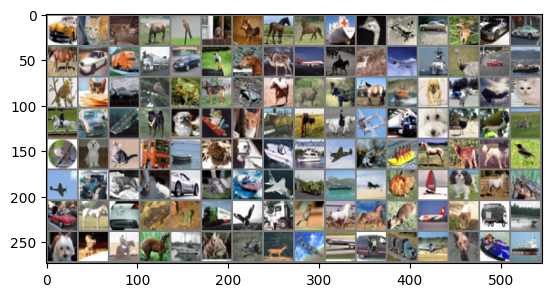

automobile  cat  deer  deer  bird  dog  dog  horse  horse  ship  bird  airplane  automobile  deer  automobile  automobile  horse  automobile  truck  truck  automobile  bird  horse  deer  airplane  horse  deer  airplane  ship  bird  automobile  ship  bird  cat  airplane  bird  frog  dog  frog  horse  deer  deer  horse  ship  dog  horse  airplane  cat  horse  automobile  ship  dog  dog  frog  cat  horse  horse  horse  airplane  truck  dog  bird  bird  deer  bird  dog  cat  truck  ship  frog  horse  ship  ship  airplane  frog  ship  horse  deer  dog  bird  airplane  truck  cat  cat  automobile  cat  ship  airplane  truck  ship  airplane  cat  ship  dog  horse  frog  automobile  horse  automobile  frog  frog  truck  bird  truck  bird  horse  horse  deer  airplane  dog  truck  ship  dog  horse  horse  deer  ship  cat  deer  deer  airplane  airplane  automobile  truck  airplane  dog  ship  ship


In [ ]:
# Dynamically get class names from the dataset
classes = dataset.classes

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images, nrow=16)
matplotlib_imshow(img_grid)
# Print labels. Displayed images in the grid (up to 16, or fewer if batch size is smaller)
print('  '.join(classes[labels[j]] for j in range(len(labels))))


In [ ]:
# We can retrieve a sample from the dataset
img, label = trainset[0]
print('Img shape: ', img.shape)
#print(img)
print('Label: ', label)

# We can sample a batch from the dataloader by running over its iterator
iter_ = iter(trainloader)
bimg, blabel = next(iter_)
print('Batch Img shape: ', bimg.shape)
print('Batch Label shape: ', blabel.shape)
print(f'The Batched tensors return a collection of {bimg.shape[0]} images \
({bimg.shape[1]} channel, {bimg.shape[2]} height pixels, {bimg.shape[3]} width pixels)')
print(f'In the case of the labels, we obtain {blabel.shape[0]} batched integers, one per image')

Img shape:  torch.Size([3, 32, 32])
Label:  8
Batch Img shape:  torch.Size([128, 3, 32, 32])
Batch Label shape:  torch.Size([128])
The Batched tensors return a collection of 128 images (3 channel, 32 height pixels, 32 width pixels)
In the case of the labels, we obtain 128 batched integers, one per image


**Convolutional Neural Networks**

When dealing with images, Convolutional Neural Networks (CNNs) are more convenient because they deal better with local correlations in the data (as with images). So now we are going to train a CNN for multiclass classification.

# Helper functions & model definitions

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model's parameters.

In [ ]:
def train_model(model, dataloader, valloader, epochs=10, model_name="Model", learning_rate=hparams['learning_rate']):
    """Standard training loop for a model."""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Save the best model
    best_val_loss = float('inf')  # Initialize with infinity
    best_model_path = f"{model_name}_best.pth"

    # Activate the train=True flag inside the model
    start_time = time.time()
    model.train()

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(epochs):
        running_loss = 0.0
        running_val_loss = 0.0
        for i, data in enumerate(tqdm(dataloader, desc=f"Training {model_name} Epoch {epoch+1}/{epochs}")):
            model.train()
            # inputs: A collection of batch_size images
            # labels: A vector of dimensionality batch_size with integers denoting class of each image
            inputs, labels = data
            # Move input data and labels to the device
            inputs, labels = inputs.to(device), labels.to(device)
            # Set network gradients to 0
            optimizer.zero_grad()
            # Forward batch of images through the network
            outputs = model(inputs)

            # outputs: Output of the network for the collection of images. A tensor of dimensionality batch_size x num_classes
            # labels: The actual labels of the images. Vector of dimensionality batch_size
            # Compute loss
            loss = criterion(outputs, labels)
            # Compute backpropagation
            loss.backward()
            # Update parameters of the network
            optimizer.step()

            # Compute metrics
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total = labels.size(0)
            correct = (predicted == labels).sum().item()

        # Validation
        for i, data in enumerate(tqdm(valloader, desc=f"Validation {model_name} Epoch {epoch+1}/{epochs}")):
            model.eval()
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            running_val_loss += val_loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val = labels.size(0)
            correct_val = (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(dataloader)
        avg_val_loss = running_val_loss / len(valloader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accs.append(100 * correct / total)
        val_accs.append(100 * correct_val / total_val)

        print(f"Epoch {epoch+1}, Loss: {avg_train_loss:.4f}, Validation loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_model_path)
            # Print text in red
            print(f"\033[31m New best model saved at epoch {epoch+1} with val_loss={avg_val_loss:.4f} \033[0m")

    end_time = time.time()
    inference = end_time - start_time
    print(f'Training time: {inference:.2f} seconds')
    return train_losses, val_losses, train_accs, val_accs, inference

def evaluate_model(model, dataloader, eval_device=device): # test function
    """Evaluates model accuracy on the test set."""
    model.to(eval_device)
    model.eval()
    correct = 0
    total = 0

    all_labels = []
    all_preds = []

    start_time = time.time()

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Evaluating"):
            images, labels = images.to(eval_device), labels.to(eval_device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # convert to numpy/list to store
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    end_time = time.time()
    latency = (end_time - start_time) / len(dataloader)
    print(f'\nEvaluation time: {latency:.2f} seconds')

    accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    print(f'\n--- Evaluation Results on the test set ---')
    print(f'Accuracy:  {accuracy:.2f} %')
    print(f'Precision: {precision:.4f}')
    print(f'Recall:    {recall:.4f}')
    print(f'F1 Score:  {f1:.4f}')
    print(f'Latency:   {latency:.4f}')

    # Detailed per-class report. Precision/recall for specifically 'cat', 'dog', 'plane', etc.
    # Support refers to the number of actual occurrences of the class in the dataset
    print("\nDetailed Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))

    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1, 'latency': latency}

def print_model_size(model, label=""):
    """Prints the size of a model in MB."""
    torch.save(model.state_dict(), "temp_model.p")
    size_mb = os.path.getsize("temp_model.p") / 1e6
    print(f"Size of {label} model: {size_mb:.2f} MB")
    os.remove("temp_model.p")
    return size_mb

def count_trainable_parameters(model):
    """Counts the number of trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def measure_flops(model, input_size=(1, 3, 32, 32), device=device):
    """
    Counts FLOPS and Parameters of a model.
    Default input_size is (1, 3, 32, 32) for CIFAR-10 and CIFAR-100.
    """
    # mathematical operations is fixed by the dimensions of the layers, not the content
    # Create dummy input on the correct device
    dummy_input = torch.randn(input_size).to(device)

    # Calculate MACs (Multiply-Accumulate Operations)
    macs, params = profile(model, inputs=(dummy_input,), verbose=False)

    # 1 MAC is roughly 2 FLOPs (multiplication + addition)
    flops = 2 * macs

    flops_str, params_str = clever_format([flops, params], "%.3f")

    print(f"FLOPS: {flops_str}")
    print(f"Params: {params_str}")

    return flops, params

# Dictionary to store all results for final comparison
results_summary = {}

In [ ]:
epochs_teacher = 10
epochs_student = 25
epochs_distill = 40
epochs_lora = 15

''' epochs_teacher = 3
epochs_student = 3
epochs_distill = 3
epochs_lora = 3 '''

' epochs_teacher = 3\nepochs_student = 3\nepochs_distill = 3\nepochs_lora = 3 '

# Teacher Model
First we stablish the teacher baseline.

For reproducibility, we need to set the torch manual seed. We train networks using different methods, so to compare them fairly,
we initialize the networks with the same weights.

Optimizing the Model Parameters. To train a model, we need a loss function and an optimizer

In [ ]:
#42, 518, 1993
seed = 518
teacher = "resnet18"

train_losses_teacher = []
val_losses_teacher = []
train_accs_teacher = []
val_accs_teacher = []

# Set the seed of the random number generator to a fixed value, so that the results will be reproducible
torch.manual_seed(seed)
print('Using seed: ', seed)

# Define the Teacher Model
if teacher == "resnet18":
  teacher_model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
  teacher_model.fc = nn.Linear(teacher_model.fc.in_features, 10) # Adapted for CIFAR-10
elif teacher == "mobilenetv2":
  teacher_model = torchvision.models.mobilenet_v2(weights='IMAGENET1K_V1')
  teacher_model.classifier[1] = nn.Linear(teacher_model.last_channel, 10)

teacher_model = teacher_model.to(device)
print("Teacher " + teacher + " model loaded.")
teacher_size = print_model_size(teacher_model, "Teacher")
print(f"Trainable parameters: {count_trainable_parameters(teacher_model):,}")
#print(teacher_model)

print("Measuring FLOPS...")
teacher_flops, _ = measure_flops(teacher_model, input_size=(1, 3, 32, 32))

# Fine-Tune the Teacher
print("\nFine-tuning the teacher model on CIFAR-10...")
_,_,_,_,teacher_latency = train_model(teacher_model, trainloader, valloader, epochs=epochs_teacher, model_name="Teacher", learning_rate=1e-3) # 10

# Evaluate the Fine-Tuned Teacher on the best model
print("Load the best Teacher model...")
teacher_model.load_state_dict(torch.load(f"Teacher_best.pth"))
teacher_model.eval()
print("\nEvaluating fine-tuned teacher model...")
eval_metrics = evaluate_model(teacher_model, testloader)

# Store baseline results
results_summary['Teacher'] = {
    'Accuracy (%)': eval_metrics['accuracy'],
    'Size (MB)': teacher_size,
    'FLOPS': teacher_flops,
    'Precision': eval_metrics['precision'],
    'Recall': eval_metrics['recall'],
    'Latency': eval_metrics['latency'],
    #'Latency_train': teacher_latency
}

Using seed:  518
Teacher resnet18 model loaded.
Size of Teacher model: 44.81 MB
Trainable parameters: 11,181,642
Measuring FLOPS...
FLOPS: 74.441M
Params: 11.182M

Fine-tuning the teacher model on CIFAR-10...


Validation Teacher Epoch 1/10: 100%|██████████| 79/79 [00:04<00:00, 19.09it/s]


Epoch 1, Loss: 0.9233, Validation loss: 0.7478
 New best model saved at epoch 1 with val_loss=0.7478 


Validation Teacher Epoch 2/10: 100%|██████████| 79/79 [00:05<00:00, 15.28it/s]


Epoch 2, Loss: 0.5905, Validation loss: 0.6366
 New best model saved at epoch 2 with val_loss=0.6366 


Validation Teacher Epoch 3/10: 100%|██████████| 79/79 [00:02<00:00, 31.53it/s]


Epoch 3, Loss: 0.4552, Validation loss: 0.6847


Validation Teacher Epoch 4/10: 100%|██████████| 79/79 [00:02<00:00, 33.22it/s]


Epoch 4, Loss: 0.3570, Validation loss: 0.5941
 New best model saved at epoch 4 with val_loss=0.5941 


Validation Teacher Epoch 5/10: 100%|██████████| 79/79 [00:02<00:00, 32.77it/s]


Epoch 5, Loss: 0.2672, Validation loss: 0.7523


Validation Teacher Epoch 6/10: 100%|██████████| 79/79 [00:02<00:00, 27.55it/s]


Epoch 6, Loss: 0.2226, Validation loss: 0.6628


Validation Teacher Epoch 7/10: 100%|██████████| 79/79 [00:02<00:00, 32.71it/s]


Epoch 7, Loss: 0.1816, Validation loss: 0.7160


Validation Teacher Epoch 8/10: 100%|██████████| 79/79 [00:04<00:00, 18.92it/s]


Epoch 8, Loss: 0.1456, Validation loss: 0.7558


Validation Teacher Epoch 9/10: 100%|██████████| 79/79 [00:02<00:00, 31.32it/s]


Epoch 9, Loss: 0.1290, Validation loss: 0.7269


Validation Teacher Epoch 10/10: 100%|██████████| 79/79 [00:05<00:00, 14.53it/s]


Epoch 10, Loss: 0.1026, Validation loss: 0.7656
Training time: 239.26 seconds
Load the best Teacher model...

Evaluating fine-tuned teacher model...


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.15it/s]



Evaluation time: 0.07 seconds

--- Evaluation Results on the test set ---
Accuracy:  79.90 %
Precision: 0.7994
Recall:    0.7990
F1 Score:  0.7984
Latency:   0.0661

Detailed Classification Report:
              precision    recall  f1-score   support

    airplane       0.84      0.84      0.84      1000
  automobile       0.86      0.89      0.87      1000
        bird       0.73      0.76      0.75      1000
         cat       0.63      0.64      0.63      1000
        deer       0.80      0.78      0.79      1000
         dog       0.73      0.66      0.69      1000
        frog       0.81      0.88      0.84      1000
       horse       0.89      0.82      0.85      1000
        ship       0.83      0.90      0.86      1000
       truck       0.88      0.83      0.86      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


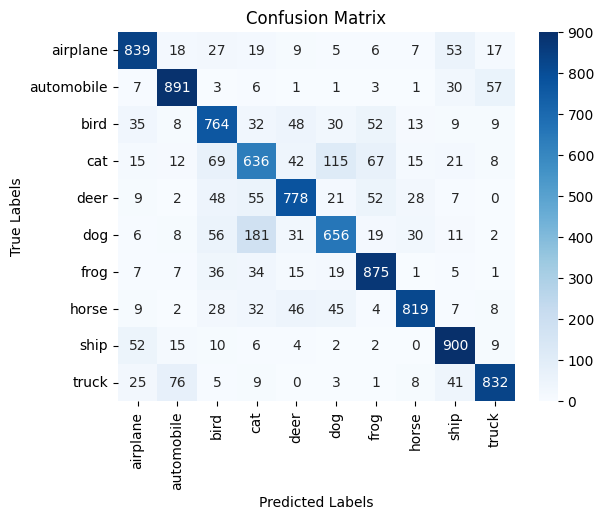

In [ ]:
all_preds=[]
all_labels=[]

with torch.inference_mode():
    for image, label in testloader:
        image, label= image.to(device), label.to(device)
        pred=teacher_model(image)
        pred_label=torch.argmax(pred, dim=1)
        all_preds.append(pred_label.cpu())
        all_labels.append(label.cpu())

all_preds=torch.cat(all_preds)
all_labels=torch.cat(all_labels)

class_name = dataset.classes
print(class_name)

cm=confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_name, yticklabels=class_name)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Student Model

For reproducibility, we need to set the torch manual seed. We train networks using different methods, so to compare them fairly, we have to initialize the networks with the same weights. Start by training the teacher network using cross-entropy:

In [ ]:
# Load Student Model. Instantiate the lightweight network
# Set the seed of the random number generator to a fixed value, so that the results will be reproducible
torch.manual_seed(seed)
print(seed)
student_model = torchvision.models.mobilenet_v2(weights=None) # Train from scratch
student_model.classifier[1] = nn.Linear(student_model.last_channel, 10) # in_features, out_features
student_model = student_model.to(device)

print("Student (MobileNetV2) model loaded.")
student_size_before = print_model_size(student_model, "Student (before distillation)")

518
Student (MobileNetV2) model loaded.
Size of Student (before distillation) model: 9.19 MB


student_model.classifier: In MobileNetV2, the final part of the network that does the actual class prediction is a sequential block called .classifier, unlike a single layer called .fc in ResNet.

[1]: This sequential block typically has two layers: [0] is a Dropout layer for regularization, and [1] is the final Linear layer that makes the prediction. This line targets and replaces that final Linear layer.

student_model.last_channel: attribute of the MobileNetV2 model that holds the number of input features the final linear layer expects. Using this ensures the new layer has the correct input size.

We instantiate one more lightweight network model to compare their performances. Back propagation is sensitive to weight initialization, so we need to make sure these two networks have the exact same initialization.



In [ ]:
torch.manual_seed(seed)
new_student_model = torchvision.models.mobilenet_v2(weights=None)
new_student_model.classifier[1] = nn.Linear(new_student_model.last_channel, 10)
new_student_model = new_student_model.to(device)

In [ ]:
# Print the total number of parameters in each model:
total_params_deep = "{:,}".format(sum(p.numel() for p in teacher_model.parameters()))
print(f"Teacher parameters: {total_params_deep}")
total_params_light = "{:,}".format(sum(p.numel() for p in student_model.parameters()))
print(f"MobileNetV2 parameters: {total_params_light}")

train_losses_student = []
val_losses_student = []
train_accs_student = []
val_accs_student = []

train_losses_student, val_losses_student, train_accs_student, val_accs_student,_ = train_model(student_model, trainloader, valloader, epochs_student, model_name="Student_no_teacher") #25 best model saved at 13

# Evaluate the Fine-Tuned Teacher on the best model
print("Load the best Student without teacher model...")
student_model.load_state_dict(torch.load(f"Student_no_teacher_best.pth"))
student_model.eval()
student_metrics_test_light_ce = evaluate_model(student_model, testloader, device)

Teacher parameters: 11,181,642
MobileNetV2 parameters: 2,236,682


Validation Student_no_teacher Epoch 1/25: 100%|██████████| 79/79 [00:02<00:00, 27.41it/s]


Epoch 1, Loss: 2.0342, Validation loss: 1.7308
 New best model saved at epoch 1 with val_loss=1.7308 


Validation Student_no_teacher Epoch 2/25: 100%|██████████| 79/79 [00:03<00:00, 22.09it/s]


Epoch 2, Loss: 1.6342, Validation loss: 1.5255
 New best model saved at epoch 2 with val_loss=1.5255 


Validation Student_no_teacher Epoch 3/25: 100%|██████████| 79/79 [00:02<00:00, 28.26it/s]


Epoch 3, Loss: 1.4651, Validation loss: 1.4387
 New best model saved at epoch 3 with val_loss=1.4387 


Validation Student_no_teacher Epoch 4/25: 100%|██████████| 79/79 [00:03<00:00, 22.85it/s]


Epoch 4, Loss: 1.3472, Validation loss: 1.3637
 New best model saved at epoch 4 with val_loss=1.3637 


Validation Student_no_teacher Epoch 5/25: 100%|██████████| 79/79 [00:03<00:00, 24.59it/s]


Epoch 5, Loss: 1.2515, Validation loss: 1.3023
 New best model saved at epoch 5 with val_loss=1.3023 


Validation Student_no_teacher Epoch 6/25: 100%|██████████| 79/79 [00:02<00:00, 28.15it/s]


Epoch 6, Loss: 1.1681, Validation loss: 1.2459
 New best model saved at epoch 6 with val_loss=1.2459 


Validation Student_no_teacher Epoch 7/25: 100%|██████████| 79/79 [00:03<00:00, 23.66it/s]


Epoch 7, Loss: 1.1003, Validation loss: 1.2267
 New best model saved at epoch 7 with val_loss=1.2267 


Validation Student_no_teacher Epoch 8/25: 100%|██████████| 79/79 [00:02<00:00, 27.81it/s]


Epoch 8, Loss: 1.0420, Validation loss: 1.1577
 New best model saved at epoch 8 with val_loss=1.1577 


Validation Student_no_teacher Epoch 9/25: 100%|██████████| 79/79 [00:03<00:00, 23.29it/s]


Epoch 9, Loss: 0.9798, Validation loss: 1.1456
 New best model saved at epoch 9 with val_loss=1.1456 


Validation Student_no_teacher Epoch 10/25: 100%|██████████| 79/79 [00:02<00:00, 27.81it/s]


Epoch 10, Loss: 0.9167, Validation loss: 1.1102
 New best model saved at epoch 10 with val_loss=1.1102 


Validation Student_no_teacher Epoch 11/25: 100%|██████████| 79/79 [00:03<00:00, 25.57it/s]


Epoch 11, Loss: 0.8707, Validation loss: 1.0520
 New best model saved at epoch 11 with val_loss=1.0520 


Validation Student_no_teacher Epoch 12/25: 100%|██████████| 79/79 [00:02<00:00, 28.41it/s]


Epoch 12, Loss: 0.8182, Validation loss: 1.0619


Validation Student_no_teacher Epoch 13/25: 100%|██████████| 79/79 [00:02<00:00, 27.72it/s]


Epoch 13, Loss: 0.7760, Validation loss: 1.0992


Validation Student_no_teacher Epoch 14/25: 100%|██████████| 79/79 [00:02<00:00, 28.37it/s]


Epoch 14, Loss: 0.7253, Validation loss: 1.0642


Validation Student_no_teacher Epoch 15/25: 100%|██████████| 79/79 [00:05<00:00, 15.33it/s]


Epoch 15, Loss: 0.6902, Validation loss: 1.0923


Validation Student_no_teacher Epoch 16/25: 100%|██████████| 79/79 [00:02<00:00, 27.88it/s]


Epoch 16, Loss: 0.6403, Validation loss: 1.0512
 New best model saved at epoch 16 with val_loss=1.0512 


Validation Student_no_teacher Epoch 17/25: 100%|██████████| 79/79 [00:03<00:00, 20.70it/s]


Epoch 17, Loss: 0.6075, Validation loss: 1.0677


Validation Student_no_teacher Epoch 18/25: 100%|██████████| 79/79 [00:02<00:00, 27.03it/s]


Epoch 18, Loss: 0.5689, Validation loss: 1.0846


Validation Student_no_teacher Epoch 19/25: 100%|██████████| 79/79 [00:03<00:00, 21.26it/s]


Epoch 19, Loss: 0.5453, Validation loss: 1.1205


Validation Student_no_teacher Epoch 20/25: 100%|██████████| 79/79 [00:02<00:00, 28.24it/s]


Epoch 20, Loss: 0.5059, Validation loss: 1.0743


Validation Student_no_teacher Epoch 21/25: 100%|██████████| 79/79 [00:03<00:00, 20.93it/s]


Epoch 21, Loss: 0.4653, Validation loss: 1.0945


Validation Student_no_teacher Epoch 22/25: 100%|██████████| 79/79 [00:02<00:00, 27.82it/s]


Epoch 22, Loss: 0.4394, Validation loss: 1.1793


Validation Student_no_teacher Epoch 23/25: 100%|██████████| 79/79 [00:03<00:00, 20.25it/s]


Epoch 23, Loss: 0.4111, Validation loss: 1.1442


Validation Student_no_teacher Epoch 24/25: 100%|██████████| 79/79 [00:02<00:00, 27.65it/s]


Epoch 24, Loss: 0.3880, Validation loss: 1.2209


Validation Student_no_teacher Epoch 25/25: 100%|██████████| 79/79 [00:03<00:00, 20.53it/s]


Epoch 25, Loss: 0.3544, Validation loss: 1.1944
Training time: 483.56 seconds
Load the best Student without teacher model...


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 29.40it/s]



Evaluation time: 0.03 seconds

--- Evaluation Results on the test set ---
Accuracy:  64.85 %
Precision: 0.6556
Recall:    0.6485
F1 Score:  0.6500
Latency:   0.0340

Detailed Classification Report:
              precision    recall  f1-score   support

    airplane       0.74      0.72      0.73      1000
  automobile       0.78      0.74      0.76      1000
        bird       0.55      0.54      0.54      1000
         cat       0.42      0.47      0.44      1000
        deer       0.59      0.56      0.57      1000
         dog       0.53      0.60      0.56      1000
        frog       0.67      0.77      0.71      1000
       horse       0.78      0.60      0.68      1000
        ship       0.76      0.80      0.78      1000
       truck       0.74      0.68      0.71      1000

    accuracy                           0.65     10000
   macro avg       0.66      0.65      0.65     10000
weighted avg       0.66      0.65      0.65     10000



Based on test accuracy, we can now compare the deeper network that is to be used as a teacher with the lightweight network that is our student.
So far, the student has not intervened with the teacher, therefore this performance is achieved by the student itself.

Teacher accuracy: 79.90%
Student accuracy: 64.85%


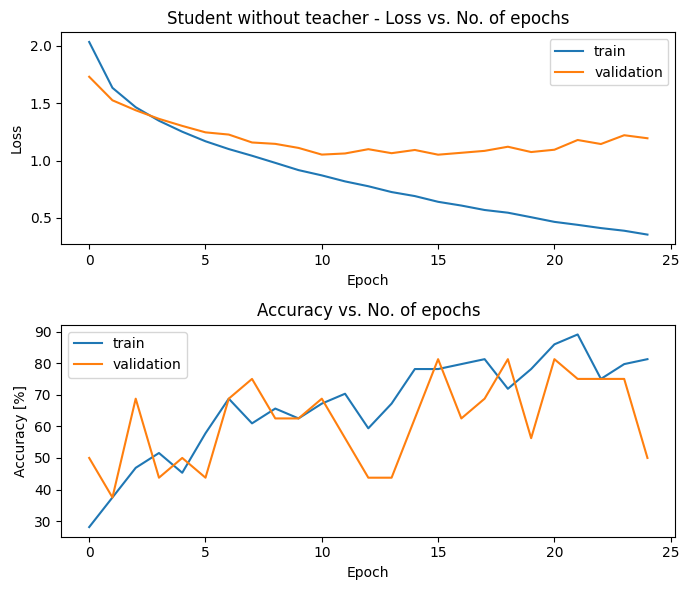

In [ ]:
print(f"Teacher accuracy: {eval_metrics['accuracy']:.2f}%")
print(f"Student accuracy: {student_metrics_test_light_ce['accuracy']:.2f}%") # performance without teacher

# Plots of the learning curves of the model
plt.figure(figsize=(7, 6))
plt.subplot(2,1,1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Student without teacher - Loss vs. No. of epochs');
plt.plot(train_losses_student, label='train')
plt.plot(val_losses_student, label='validation')
plt.legend()
plt.subplot(2,1,2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.title('Accuracy vs. No. of epochs');
plt.plot(train_accs_student, label='train')
plt.plot(val_accs_student, label='validation')
plt.legend()
plt.tight_layout()
plt.show()

# Knowledge distillation

Now we try to improve the test accuracy of the student by distilling the teacher. Both networks output a probability distribution over classes, which means they share the same number of output neurons.

A few extra parameters:

- T: Temperature controls the smoothness of the output distributions.
- soft_target_loss_weight
- ce_loss_weight: A weight assigned to cross-entropy


In [ ]:
train_losses_distilled = []
test_losses_distilled = []
val_losses_distilled = []
train_accs_distilled = []
test_accs_distilled = []
val_accs_distilled = []

# Define Distillation Loss
def distillation_loss(student_logits, teacher_logits, labels, temperature, alpha):
    # Calculate the soft targets loss. Scaled by T**2 as suggested by the authors of the paper "Distilling the knowledge in a neural network"
    soft_loss = nn.KLDivLoss(reduction='batchmean')(
        F.log_softmax(student_logits / temperature, dim=1), # Soften the student logits by applying log() and softmax
        F.softmax(teacher_logits / temperature, dim=1)
    ) * (temperature * temperature)
    # Calculate the true label loss
    hard_loss = F.cross_entropy(student_logits, labels)
    # Weighted sum of the two losses
    return alpha * soft_loss + (1.0 - alpha) * hard_loss

# Train the Student with Distillation
optimizer = optim.Adam(student_model.parameters(), lr=0.001)
# Set the weights to 0.75 for CE and 0.25 for distillation loss.
temperature = 4.0
alpha = 0.75
#epochs_distill = 30

print("\nStarting distillation training...")
#teacher_model.eval() # Set teacher to evaluation mode for distillation
student_model.train()
best_val_loss = float('inf')
student_best_model_path = "student_best.pth"
correct = total = acc = 0
total_train = correct_train = 0

for epoch in range(epochs_distill): # train and val
    running_loss = 0.0
    running_val_loss = 0.0
    for i, data in enumerate(tqdm(trainloader, desc=f"Distill Epoch {epoch+1}/{epochs_distill}")):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        # Forward pass with the student model
        student_outputs = student_model(inputs)
        # Forward pass with the teacher model - do not save gradients here as we do not change the teacher's weights
        with torch.no_grad():
            teacher_outputs = teacher_model(inputs)

        loss = distillation_loss(student_outputs, teacher_outputs, labels, temperature, alpha)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(student_outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        student_model.eval()

    with torch.no_grad(): # validation
        for i, data in enumerate(tqdm(valloader, desc=f"Validation Distill Epoch {epoch+1}/{epochs_distill}")):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            student_outputs = student_model(inputs)
            teacher_outputs = teacher_model(inputs)  # still eval mode, no grad
            val_loss = distillation_loss(student_outputs, teacher_outputs, labels, temperature, alpha)
            running_val_loss += val_loss.item()

            _, predicted = torch.max(student_outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(trainloader)
    avg_val_loss = running_val_loss / len(valloader)

    train_losses_distilled.append(avg_train_loss)
    val_losses_distilled.append(avg_val_loss)
    train_accs_distilled.append(100 * correct_train / total_train) # avg_train_acc
    val_accs_distilled.append(100 * correct / total) # avg_val_acc

    print(f"Distill Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Save the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(student_model.state_dict(), student_best_model_path)

        # Print text in red
        print(f'\033[31m Best student model saved at epoch {epoch+1} with val_loss={avg_val_loss:.4f} \033[0m')

print("\nDistillation complete.")



Starting distillation training...


Validation Distill Epoch 1/40: 100%|██████████| 79/79 [00:02<00:00, 27.51it/s]


Distill Epoch 1, Train Loss: 1.4631, Val Loss: 1.7485
 Best student model saved at epoch 1 with val_loss=1.7485 


Validation Distill Epoch 2/40: 100%|██████████| 79/79 [00:02<00:00, 27.63it/s]


Distill Epoch 2, Train Loss: 1.2704, Val Loss: 1.7235
 Best student model saved at epoch 2 with val_loss=1.7235 


Validation Distill Epoch 3/40: 100%|██████████| 79/79 [00:02<00:00, 26.58it/s]


Distill Epoch 3, Train Loss: 1.1499, Val Loss: 1.7289


Validation Distill Epoch 4/40: 100%|██████████| 79/79 [00:02<00:00, 27.01it/s]


Distill Epoch 4, Train Loss: 1.1020, Val Loss: 1.7173
 Best student model saved at epoch 4 with val_loss=1.7173 


Validation Distill Epoch 5/40: 100%|██████████| 79/79 [00:02<00:00, 27.54it/s]


Distill Epoch 5, Train Loss: 1.0530, Val Loss: 1.6396
 Best student model saved at epoch 5 with val_loss=1.6396 


Validation Distill Epoch 6/40: 100%|██████████| 79/79 [00:02<00:00, 27.73it/s]


Distill Epoch 6, Train Loss: 1.0317, Val Loss: 1.5593
 Best student model saved at epoch 6 with val_loss=1.5593 


Validation Distill Epoch 7/40: 100%|██████████| 79/79 [00:03<00:00, 26.25it/s]


Distill Epoch 7, Train Loss: 0.9338, Val Loss: 1.6037


Validation Distill Epoch 8/40: 100%|██████████| 79/79 [00:02<00:00, 27.98it/s]


Distill Epoch 8, Train Loss: 0.9163, Val Loss: 1.6030


Validation Distill Epoch 9/40: 100%|██████████| 79/79 [00:03<00:00, 24.63it/s]


Distill Epoch 9, Train Loss: 0.9087, Val Loss: 1.5931


Validation Distill Epoch 10/40: 100%|██████████| 79/79 [00:02<00:00, 27.21it/s]


Distill Epoch 10, Train Loss: 0.8913, Val Loss: 1.6124


Validation Distill Epoch 11/40: 100%|██████████| 79/79 [00:03<00:00, 24.45it/s]


Distill Epoch 11, Train Loss: 0.8396, Val Loss: 1.5770


Validation Distill Epoch 12/40: 100%|██████████| 79/79 [00:02<00:00, 28.41it/s]


Distill Epoch 12, Train Loss: 0.8233, Val Loss: 1.4919
 Best student model saved at epoch 12 with val_loss=1.4919 


Validation Distill Epoch 13/40: 100%|██████████| 79/79 [00:03<00:00, 25.12it/s]


Distill Epoch 13, Train Loss: 0.8076, Val Loss: 1.5575


Validation Distill Epoch 14/40: 100%|██████████| 79/79 [00:02<00:00, 27.22it/s]


Distill Epoch 14, Train Loss: 0.7752, Val Loss: 1.5423


Validation Distill Epoch 15/40: 100%|██████████| 79/79 [00:03<00:00, 25.16it/s]


Distill Epoch 15, Train Loss: 0.7668, Val Loss: 1.5029


Validation Distill Epoch 16/40: 100%|██████████| 79/79 [00:02<00:00, 28.20it/s]


Distill Epoch 16, Train Loss: 0.7532, Val Loss: 1.4886
 Best student model saved at epoch 16 with val_loss=1.4886 


Validation Distill Epoch 17/40: 100%|██████████| 79/79 [00:02<00:00, 26.55it/s]


Distill Epoch 17, Train Loss: 0.7442, Val Loss: 1.6608


Validation Distill Epoch 18/40: 100%|██████████| 79/79 [00:02<00:00, 28.08it/s]


Distill Epoch 18, Train Loss: 0.7070, Val Loss: 1.4614
 Best student model saved at epoch 18 with val_loss=1.4614 


Validation Distill Epoch 19/40: 100%|██████████| 79/79 [00:02<00:00, 27.75it/s]


Distill Epoch 19, Train Loss: 0.7012, Val Loss: 1.5371


Validation Distill Epoch 20/40: 100%|██████████| 79/79 [00:02<00:00, 27.92it/s]


Distill Epoch 20, Train Loss: 0.6994, Val Loss: 1.4706


Validation Distill Epoch 21/40: 100%|██████████| 79/79 [00:02<00:00, 28.08it/s]


Distill Epoch 21, Train Loss: 0.6861, Val Loss: 1.4173
 Best student model saved at epoch 21 with val_loss=1.4173 


Validation Distill Epoch 22/40: 100%|██████████| 79/79 [00:02<00:00, 27.93it/s]


Distill Epoch 22, Train Loss: 0.6547, Val Loss: 1.4598


Validation Distill Epoch 23/40: 100%|██████████| 79/79 [00:02<00:00, 28.03it/s]


Distill Epoch 23, Train Loss: 0.6415, Val Loss: 1.4435


Validation Distill Epoch 24/40: 100%|██████████| 79/79 [00:02<00:00, 28.13it/s]


Distill Epoch 24, Train Loss: 0.6380, Val Loss: 1.5112


Validation Distill Epoch 25/40: 100%|██████████| 79/79 [00:02<00:00, 28.04it/s]


Distill Epoch 25, Train Loss: 0.6530, Val Loss: 1.4494


Validation Distill Epoch 26/40: 100%|██████████| 79/79 [00:03<00:00, 25.34it/s]


Distill Epoch 26, Train Loss: 0.6095, Val Loss: 1.4297


Validation Distill Epoch 27/40: 100%|██████████| 79/79 [00:02<00:00, 27.74it/s]


Distill Epoch 27, Train Loss: 0.5996, Val Loss: 1.4542


Validation Distill Epoch 28/40: 100%|██████████| 79/79 [00:03<00:00, 25.11it/s]


Distill Epoch 28, Train Loss: 0.5984, Val Loss: 1.4491


Validation Distill Epoch 29/40: 100%|██████████| 79/79 [00:02<00:00, 28.09it/s]


Distill Epoch 29, Train Loss: 0.5949, Val Loss: 1.4645


Validation Distill Epoch 30/40: 100%|██████████| 79/79 [00:03<00:00, 25.87it/s]


Distill Epoch 30, Train Loss: 0.5872, Val Loss: 1.3905
 Best student model saved at epoch 30 with val_loss=1.3905 


Validation Distill Epoch 31/40: 100%|██████████| 79/79 [00:02<00:00, 27.98it/s]


Distill Epoch 31, Train Loss: 0.5841, Val Loss: 1.4211


Validation Distill Epoch 32/40: 100%|██████████| 79/79 [00:03<00:00, 26.20it/s]


Distill Epoch 32, Train Loss: 0.5959, Val Loss: 1.3860
 Best student model saved at epoch 32 with val_loss=1.3860 


Validation Distill Epoch 33/40: 100%|██████████| 79/79 [00:02<00:00, 27.51it/s]


Distill Epoch 33, Train Loss: 0.5711, Val Loss: 1.3917


Validation Distill Epoch 34/40: 100%|██████████| 79/79 [00:02<00:00, 26.60it/s]


Distill Epoch 34, Train Loss: 0.5419, Val Loss: 1.3646
 Best student model saved at epoch 34 with val_loss=1.3646 


Validation Distill Epoch 35/40: 100%|██████████| 79/79 [00:02<00:00, 27.91it/s]


Distill Epoch 35, Train Loss: 0.5884, Val Loss: 1.4063


Validation Distill Epoch 36/40: 100%|██████████| 79/79 [00:02<00:00, 26.55it/s]


Distill Epoch 36, Train Loss: 0.5535, Val Loss: 1.4668


Validation Distill Epoch 37/40: 100%|██████████| 79/79 [00:02<00:00, 27.58it/s]


Distill Epoch 37, Train Loss: 0.5338, Val Loss: 1.3560
 Best student model saved at epoch 37 with val_loss=1.3560 


Validation Distill Epoch 38/40: 100%|██████████| 79/79 [00:03<00:00, 25.76it/s]


Distill Epoch 38, Train Loss: 0.5151, Val Loss: 1.4109


Validation Distill Epoch 39/40: 100%|██████████| 79/79 [00:02<00:00, 27.32it/s]


Distill Epoch 39, Train Loss: 0.5433, Val Loss: 1.4082


Validation Distill Epoch 40/40: 100%|██████████| 79/79 [00:03<00:00, 24.17it/s]

Distill Epoch 40, Train Loss: 0.5156, Val Loss: 1.3861

Distillation complete.


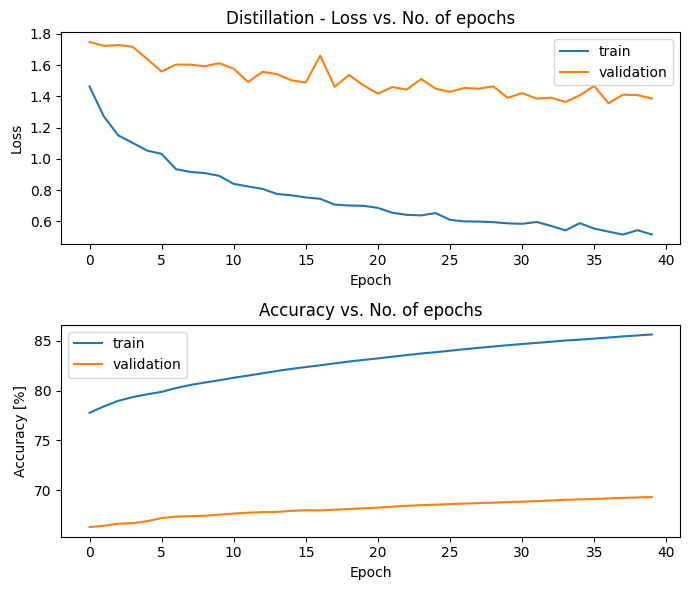

In [ ]:
# Plots of the learning curves of the distilled model
plt.figure(figsize=(7, 4))
plt.subplot(2,1,1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Distillation - Loss vs. No. of epochs');
plt.plot(train_losses_distilled, label='train')
plt.plot(val_losses_distilled, label='validation')
plt.legend()
plt.subplot(2,1,2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.title('Accuracy vs. No. of epochs');
plt.plot(train_accs_distilled, label='train')
plt.plot(val_accs_distilled, label='validation')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
distilled_student_model = copy.deepcopy(student_model)
distilled_student_model.load_state_dict(torch.load(student_best_model_path, map_location=device))
distilled_student_model.eval()

distilled_student_metrics = evaluate_model(distilled_student_model, testloader) # test_accuracy_light_ce_and_kd
distilled_size = print_model_size(distilled_student_model, "Distilled Student")
print(f"Trainable parameters: {count_trainable_parameters(distilled_student_model):,}")
#print(distilled_student_model)

print("Measuring FLOPS...")
distilled_flops, _ = measure_flops(distilled_student_model, input_size=(1, 3, 32, 32))

# Update results dictionary
results_summary['Distilled Student'] = {
    'Accuracy (%)': distilled_student_metrics['accuracy'],
    'Size (MB)': distilled_size,
    'FLOPS': distilled_flops,
    'Precision': distilled_student_metrics['precision'],
    'Recall': distilled_student_metrics['recall'],
    'Latency': distilled_student_metrics['latency']
}

Evaluating: 100%|██████████| 79/79 [00:02<00:00, 31.28it/s]



Evaluation time: 0.03 seconds

--- Evaluation Results on the test set ---
Accuracy:  70.46 %
Precision: 0.7098
Recall:    0.7046
F1 Score:  0.7055
Latency:   0.0320

Detailed Classification Report:
              precision    recall  f1-score   support

    airplane       0.76      0.73      0.75      1000
  automobile       0.82      0.83      0.82      1000
        bird       0.62      0.61      0.61      1000
         cat       0.48      0.56      0.52      1000
        deer       0.63      0.70      0.66      1000
         dog       0.63      0.54      0.58      1000
        frog       0.75      0.78      0.76      1000
       horse       0.83      0.68      0.75      1000
        ship       0.81      0.82      0.82      1000
       truck       0.76      0.80      0.78      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.71     10000
weighted avg       0.71      0.70      0.71     10000

Size of Distilled Student model: 9.19 MB
T

In [ ]:
# Compare the student test accuracy with and without the teacher, after distillation
print(f"Teacher accuracy: {eval_metrics['accuracy']:.2f}%")
print(f"Student accuracy without teacher: {student_metrics_test_light_ce['accuracy']:.2f}%")
print(f"Student accuracy with CE + KD: {distilled_student_metrics['accuracy']:.2f}%")

Teacher accuracy: 79.90%
Student accuracy without teacher: 64.85%
Student accuracy with CE + KD: 70.46%


# LoRA Fine-Tuning

In [ ]:
train_losses_lora = []
val_losses_lora = []
train_accs_lora = []
test_accs_lora = []

# Apply LoRA to the Distilled Student Model
lora_config = LoraConfig(
    r=8,                # LoRA rank
    lora_alpha=16,      # LoRA alpha (scaling)
    target_modules=["features.0.0", "features.18.0"],   # Target specific modules for LoRA adaptation
    lora_dropout=0.1,   # Dropout probability
    bias="none",        # Don't use bias terms
)

lora_student_model = get_peft_model(distilled_student_model, lora_config)
print("LoRA adapters applied to the distilled student model.")
print(f"Trainable parameters with LoRA: {count_trainable_parameters(lora_student_model):,}")
lora_student_model.print_trainable_parameters()

# Fine-tune the LoRA-adapted model
#epochs_lora = 15

print("\nStarting LoRA fine-tuning...")
train_losses_lora, val_losses_lora, train_accs_lora, val_accs_lora, _ = train_model(lora_student_model, trainloader, valloader, epochs=epochs_lora, model_name="LoRA Student")

print("\nLoRA fine-tuning complete.")
lora_student_model = lora_student_model.merge_and_unload()
lora_metrics = evaluate_model(lora_student_model, testloader)
lora_size = print_model_size(lora_student_model, "LoRA-tuned Student")

print("Measuring FLOPS...")
lora_flops, lora_params = measure_flops(lora_student_model, input_size=(1, 3, 32, 32))
print(count_trainable_parameters(lora_student_model))
print(lora_params)

# Update results dictionary
results_summary['LoRA-tuned Student'] = {
    'Accuracy (%)': lora_metrics['accuracy'],
    'Size (MB)': lora_size,
    'FLOPS': lora_flops,
    'Precision': lora_metrics['precision'],
    'Recall': lora_metrics['recall'],
    'Latency': lora_metrics['latency']
}

LoRA adapters applied to the distilled student model.
Trainable parameters with LoRA: 13,272
trainable params: 13,272 || all params: 2,249,954 || trainable%: 0.5899

Starting LoRA fine-tuning...


Validation LoRA Student Epoch 1/15: 100%|██████████| 79/79 [00:02<00:00, 28.28it/s]


Epoch 1, Loss: 0.5680, Validation loss: 0.9728
 New best model saved at epoch 1 with val_loss=0.9728 


Validation LoRA Student Epoch 2/15: 100%|██████████| 79/79 [00:03<00:00, 24.04it/s]


Epoch 2, Loss: 0.5025, Validation loss: 0.9646
 New best model saved at epoch 2 with val_loss=0.9646 


Validation LoRA Student Epoch 3/15: 100%|██████████| 79/79 [00:02<00:00, 27.90it/s]


Epoch 3, Loss: 0.4953, Validation loss: 0.9848


Validation LoRA Student Epoch 4/15: 100%|██████████| 79/79 [00:03<00:00, 23.25it/s]


Epoch 4, Loss: 0.4901, Validation loss: 0.9621
 New best model saved at epoch 4 with val_loss=0.9621 


Validation LoRA Student Epoch 5/15: 100%|██████████| 79/79 [00:02<00:00, 28.53it/s]


Epoch 5, Loss: 0.4840, Validation loss: 0.9518
 New best model saved at epoch 5 with val_loss=0.9518 


Validation LoRA Student Epoch 6/15: 100%|██████████| 79/79 [00:02<00:00, 28.14it/s]


Epoch 6, Loss: 0.4801, Validation loss: 0.9498
 New best model saved at epoch 6 with val_loss=0.9498 


Validation LoRA Student Epoch 7/15: 100%|██████████| 79/79 [00:03<00:00, 21.22it/s]


Epoch 7, Loss: 0.4818, Validation loss: 0.9524


Validation LoRA Student Epoch 8/15: 100%|██████████| 79/79 [00:02<00:00, 28.57it/s]


Epoch 8, Loss: 0.4770, Validation loss: 0.9469
 New best model saved at epoch 8 with val_loss=0.9469 


Validation LoRA Student Epoch 9/15: 100%|██████████| 79/79 [00:02<00:00, 28.60it/s]


Epoch 9, Loss: 0.4729, Validation loss: 0.9410
 New best model saved at epoch 9 with val_loss=0.9410 


Validation LoRA Student Epoch 10/15: 100%|██████████| 79/79 [00:03<00:00, 24.93it/s]


Epoch 10, Loss: 0.4760, Validation loss: 0.9543


Validation LoRA Student Epoch 11/15: 100%|██████████| 79/79 [00:02<00:00, 27.17it/s]


Epoch 11, Loss: 0.4736, Validation loss: 0.9577


Validation LoRA Student Epoch 12/15: 100%|██████████| 79/79 [00:03<00:00, 24.54it/s]


Epoch 12, Loss: 0.4699, Validation loss: 0.9624


Validation LoRA Student Epoch 13/15: 100%|██████████| 79/79 [00:02<00:00, 28.29it/s]


Epoch 13, Loss: 0.4697, Validation loss: 0.9624


Validation LoRA Student Epoch 14/15: 100%|██████████| 79/79 [00:02<00:00, 28.41it/s]


Epoch 14, Loss: 0.4680, Validation loss: 0.9635


Validation LoRA Student Epoch 15/15: 100%|██████████| 79/79 [00:03<00:00, 20.96it/s]


Epoch 15, Loss: 0.4741, Validation loss: 0.9529
Training time: 262.71 seconds

LoRA fine-tuning complete.


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 30.29it/s]



Evaluation time: 0.03 seconds

--- Evaluation Results on the test set ---
Accuracy:  69.16 %
Precision: 0.6911
Recall:    0.6916
F1 Score:  0.6911
Latency:   0.0331

Detailed Classification Report:
              precision    recall  f1-score   support

    airplane       0.73      0.75      0.74      1000
  automobile       0.81      0.82      0.82      1000
        bird       0.62      0.58      0.60      1000
         cat       0.49      0.48      0.48      1000
        deer       0.64      0.64      0.64      1000
         dog       0.57      0.58      0.57      1000
        frog       0.73      0.78      0.76      1000
       horse       0.73      0.72      0.72      1000
        ship       0.80      0.82      0.81      1000
       truck       0.79      0.74      0.77      1000

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000

Size of LoRA-tuned Student model: 9.23 MB


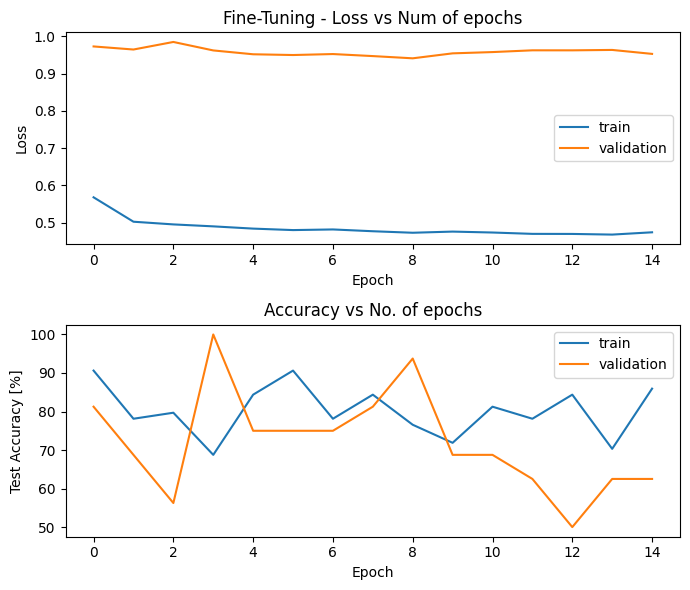

In [ ]:
# Plots of the learning curves
plt.figure(figsize=(7, 6))
plt.subplot(2,1,1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Fine-Tuning - Loss vs Num of epochs');
plt.plot(train_losses_lora, label='train')
plt.plot(val_losses_lora, label='validation')
plt.legend()
plt.subplot(2,1,2)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy [%]')
plt.title('Accuracy vs No. of epochs');
plt.plot(train_accs_lora, label='train')
plt.plot(val_accs_lora, label='validation')
plt.legend()
plt.tight_layout()
plt.show()

# Quantization

In [ ]:
# Dynamic Quantization
quantized_model = copy.deepcopy(lora_student_model).to("cpu")
quantized_model.eval()
quantized_model_dynamic = torch.quantization.quantize_dynamic(
    quantized_model, {nn.Linear}, dtype=torch.qint8
)
print("Dynamic quantization applied to the model's linear layers.")
quantized_size = print_model_size(quantized_model_dynamic, "Final Quantized Student")

# Evaluate the Quantized Model
print("\nEvaluating final quantized model on CPU...")
quantized_metrics = evaluate_model(quantized_model_dynamic, testloader, eval_device="cpu")
results_summary['Quantized Student'] = {
    'Accuracy (%)': quantized_metrics['accuracy'],
    'Size (MB)': quantized_size,
    'FLOPS': lora_flops,
    'Precision': quantized_metrics['precision'],
    'Recall': quantized_metrics['recall'],
    'Latency': quantized_metrics['latency']
}

/tmp/ipython-input-1337764476.py:4: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  quantized_model_dynamic = torch.quantization.quantize_dynamic(


Dynamic quantization applied to the model's linear layers.
Size of Final Quantized Student model: 9.18 MB

Evaluating final quantized model on CPU...


Evaluating: 100%|██████████| 79/79 [00:09<00:00,  8.68it/s]



Evaluation time: 0.12 seconds

--- Evaluation Results on the test set ---
Accuracy:  69.22 %
Precision: 0.6916
Recall:    0.6922
F1 Score:  0.6916
Latency:   0.1153

Detailed Classification Report:
              precision    recall  f1-score   support

    airplane       0.73      0.75      0.74      1000
  automobile       0.81      0.83      0.82      1000
        bird       0.63      0.59      0.61      1000
         cat       0.49      0.48      0.49      1000
        deer       0.63      0.64      0.64      1000
         dog       0.57      0.57      0.57      1000
        frog       0.73      0.78      0.76      1000
       horse       0.73      0.72      0.72      1000
        ship       0.80      0.82      0.81      1000
       truck       0.79      0.75      0.77      1000

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000



# Results summary

In [ ]:
print("Using seed", seed, "for reproducibility.")
print("Teacher " + teacher)
print("Epochs distillation:", epochs_distill)
print("Epochs fine-tuning:", epochs_lora)

# Convert the dictionary to a pandas DataFrame for nice printing
results_df = pd.DataFrame.from_dict(results_summary, orient='index')
print(results_df)

# Calculate and print the key takeaways
teacher_acc = results_summary['Teacher']['Accuracy (%)']
final_acc = results_summary['LoRA-tuned Student']['Accuracy (%)']
teacher_size_mb = results_summary['Teacher']['Size (MB)']
final_size_mb = results_summary['LoRA-tuned Student']['Size (MB)']

print("\n--- Key Takeaways ---")
print(f"Teacher Baseline Accuracy: {teacher_acc:.2f}%")
print(f"Final Student Accuracy: {final_acc:.2f}%")
print(f"\nAccuracy Retained: {(final_acc / teacher_acc) * 100:.2f}% of the teacher's performance.")
print(f"Model Size Reduction: {(1 - final_size_mb / teacher_size_mb) * 100:.2f}% smaller than the teacher.")

Using seed 518 for reproducibility.
Teacher resnet18
Epochs distillation: 40
Epochs fine-tuning: 15
                    Accuracy (%)  Size (MB)       FLOPS  Precision  Recall  \
Teacher                    79.90  44.806155  74440704.0   0.799368  0.7990   
Distilled Student          70.46   9.192331  13340160.0   0.709833  0.7046   
LoRA-tuned Student         69.16   9.225781  13340160.0   0.691087  0.6916   
Quantized Student          69.22   9.182327  13340160.0   0.691595  0.6922   

                     Latency  
Teacher             0.066080  
Distilled Student   0.031992  
LoRA-tuned Student  0.033060  
Quantized Student   0.115319  

--- Key Takeaways ---
Teacher Baseline Accuracy: 79.90%
Final Student Accuracy: 69.16%

Accuracy Retained: 86.56% of the teacher's performance.
Model Size Reduction: 79.41% smaller than the teacher.


# Analysis

## Overall Assessment
The results have achieved a better performance after distillation and some effectiveness of LoRA fine-tuning.

- Teacher accuracy: 81.89%
- Student accuracy without teacher: 63.71%
- Student accuracy with CE + KD: 68.21%

None of the methods above increase the number of parameters for the network or inference time, so the performance increase comes at the little cost of calculating gradients during training. In ML applications, we mostly care about inference time because training happens before the model deployment. If our lightweight model is still too heavy for deployment, we can apply different ideas, such as post-training quantization.

## Final Summary

| Model Stage            | Accuracy (%) | Size (MB) | % of Teacher Accuracy | % of Teacher Size |
|------------------------|--------------|-----------|-----------------------|-------------------|
| Teacher                | 78.76        | 44.80     | 100.0%                | 100.0%            |
| Student without Distillation    | 63.71        | 9.19      | 77.79%                | 21.5%             |
| Distilled Student      | 68.21        | 9.19      | 83.29%                | 21.5%             |
| LoRA-tuned Student     | 68.23        | 9.19      | 83.32%                | 21.5%             |
| Quantized Student      | 68.23        | 9.19      | 83.32%                | 21.5%             |